In [ ]:
import h5py
from scipy.stats import binned_statistic

In [61]:
spikes_box = {}
i0 = 0
for rat_name, day_name, sess_name, mod_name in (('R', 'day2', 'OF', '1'),
                                                ('R', 'day2', 'OF', '2'),
                                                ('R', 'day2', 'OF', '3'),
                                                ('Q', '', 'OF', '1'),
                                                ('Q', '', 'OF', '2'),
                                                ('S', '', 'OF', '1')):
    spikes_box_temp = get_spikes(rat_name, mod_name, day_name, sess_name, 
                                 bBinned = False, bSpeed = True, bStart = True)
    for i in range(len(spikes_box_temp)):
        spikes_box[i0+i] = spikes_box_temp[i]
    i0 += len(spikes_box_temp)
    print(len(spikes_box_temp), i0)

189 189
172 361
183 544
97 641
66 707
140 847


Compute temporal autocorrelograms for all neurons 

In [62]:
acorr_OF = get_isi_acorr(spikes_box, bLog = False, bOne = True, maxt = 0.2)


Process autocorrelograms 

In [63]:
acorr_scaled_OF = np.zeros(acorr_OF.shape)
for i in range(len(acorr_scaled_OF[:,0])):
    acorr_scaled_OF[i,:] = acorr_OF[i,:].astype(float).copy()/float(acorr_OF[i,0])
acorr_scaled_OF[:,0] = 0
acorr_s = gaussian_filter1d(acorr_scaled_OF[:, :],sigma = 4, axis = 1)
metric = 'cosine'
inds_spec = np.arange(len(acorr_s[:,0]))
X1 = squareform(pdist(acorr_s, 'cosine'))

Use Tomato to cluster the autocorrelograms 

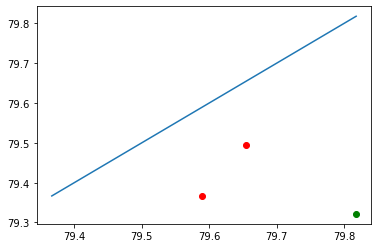

bincount [523 229  95]


In [64]:
nbs = 80
knn_indices = np.argsort(X1)[:, :nbs]
knn_dists = X1[np.arange(X1.shape[0])[:, None], knn_indices].copy()
F = np.sum(np.exp(-knn_dists),1)
from gudhi.clustering.tomato import Tomato
t = Tomato(graph_type = 'manual', density_type = 'manual', metric = 'precomputed')
t.fit(knn_indices, weights = F)
t.plot_diagram()
t.n_clusters_=4
ind = t.labels_
bind = np.bincount(ind)
print('bincount', bind)

(-0.5, 188.5, 188.5, -0.5)

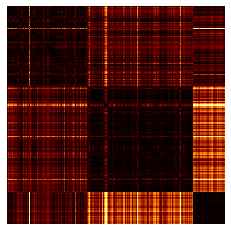

In [65]:
plt.figure()
X4 = X1[:189,:]
X4 = X4[:,:189]
X4 = X4[np.argsort(ind[:189]),:].copy()
X4 = X4[:,np.argsort(ind[:189])]
plt.imshow(X4, cmap = 'afmhot')
plt.axis('off')


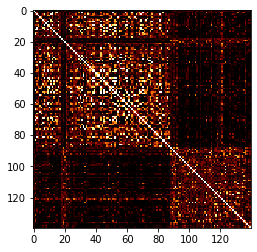

In [117]:
spk = get_spikes('S', '1', '', 'SWS', bSmooth = True, bSpeed = False)
X1 = np.corrcoef(spk.T)
X4 = X1[np.argsort(ind[-140:]),:]
X4 = X4[:,np.argsort(ind[-140:])]
plt.figure()
corrall =  np.sort(X4[np.triu_indices(X4.shape[0],1)])
indmax = int(len(corrall)*0.99)
vmax = corrall[indmax]
vmin = 0
plt.imshow(X4, cmap = 'afmhot', vmin = vmin, vmax = vmax)



In [144]:
indscurr1 = ind[:189]
indscurr = np.argsort(indscurr1)

In [ ]:
spk = get_spikes('R', '1', 'day2', 'SWS', bSmooth = True, bSpeed = False)

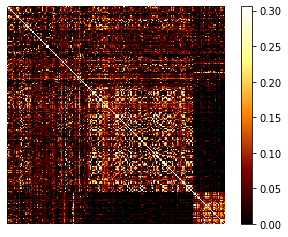

In [146]:
X1 = np.corrcoef(spk.T)
X4 = X1[indscurr,:]
X4 = X4[:,indscurr]
plt.figure()
corrall =  np.sort(X4[np.triu_indices(X4.shape[0],1)])
indmax = int(len(corrall)*0.99)
#indmin = int(len(corrall)*0.01)
vmax = corrall[indmax]
#vmin = corrall[indmin]
vmin = 0
plt.imshow(X4, cmap = 'afmhot', vmin = vmin, vmax = vmax)
plt.axis('off')
plt.colorbar()
#plt.savefig('Figs_review/corrcoef_S1')

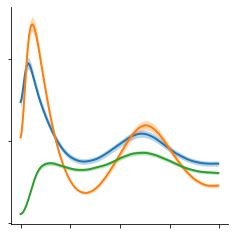

In [147]:

cs = ['#1f77b4', '#ff7f0e', '#2ca02c']
bind = np.bincount(ind)
#cs = ['b', 'g', 'r']
ax = plt.axes()
for i in np.unique(ind):
    acorrtmp = acorr_s[np.where(ind==i)[0],:].T
    acorrmean = acorrtmp.mean(1)
    acorrstd = 1*acorrtmp.std(1)/np.sqrt(len(acorrtmp[:,0]))
    ax.plot(acorrmean, lw = 2, c= cs[i], alpha = 1, label = 'Class ' + str(i+1))
    ax.fill_between(np.arange(len(acorrmean)),acorrmean, acorrmean + acorrstd,
                    lw = 0, color= cs[i], alpha = 0.3)
    ax.fill_between(np.arange(len(acorrmean)),acorrmean, acorrmean - acorrstd,
                    lw = 0, color= cs[i], alpha = 0.3)
    ax.set_aspect(1/ax.get_data_ratio())
plt.xticks([0,50,100,150,200], ['', '', '', '',''])
plt.yticks(np.arange(0,3,1)/100, ['','',''])
plt.gca().axes.spines['top'].set_visible(False)
plt.gca().axes.spines['right'].set_visible(False)


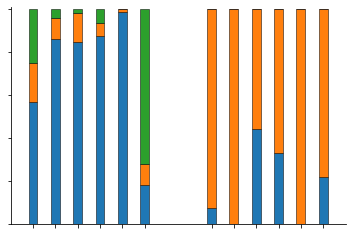

In [148]:
plt.figure()
classes = np.unique(ind)
mods = np.unique(indsall).astype(int)
distrs = np.zeros((len(classes), len(mods)))
for i in classes: 
    for j in mods:
        distrs[i,j] = np.sum((indsall==j) & (ind==i))/sum((indsall==j))

cs = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i in classes:
    for j in mods:
        if j%2 ==1:
            plt.bar(np.arange(int(j/2)+8,int(j/2)+1+8), distrs[i,j],width = 0.4, 
                    bottom = np.sum(distrs[:i+1,j])-distrs[i,j],
                edgecolor = [[0.,0.,0.]],  lw = 0.5, color = [cs[i]])
        else:
            plt.bar(np.arange(int(j/2),int(j/2)+1), distrs[i,j],width = 0.4, 
                    bottom = np.sum(distrs[:i+1,j])-distrs[i,j],
                edgecolor = [[0.,0.,0.]],  lw = 0.5, color = [cs[i]])
plt.ylim([0,1.01])
plt.xlim([-1,14])
plt.xticks(np.concatenate((np.arange(6), np.arange(6)+8)),['' for i in np.concatenate((np.arange(6), np.arange(6)+8))])
plt.yticks([],[])
plt.yticks(np.arange(0,12,2)/10, ['' for i in np.arange(0,12,2)])
plt.gca().axes.spines['top'].set_visible(False)
plt.gca().axes.spines['right'].set_visible(False)


In [163]:
xt = np.log10(np.arange(3,61,2)/1000)
pws = [0.5,1,1.5]
#xt1 = np.log10(np.power(10,pws)/1000)
#xt = np.concatenate((xt1, xt))
yt = np.zeros(len(xt)).astype(str)
yt[:] = ''
yt[0] = '$10^{0.5}$'
yt[1] = '$10^1$'
yt[2] = '$10^{1.5}$'


tot_path = 'acorrpeak_spkwidth.mat'
marvin = sio.loadmat(tot_path)
rat_mod_name = marvin['mod_name'][0,:]
ids = marvin['ids'][0,:]
acorr_peak = np.array(marvin['acorr_peak'][0,:])
spk_width =  np.array(marvin['spk_width'][0,:])
is_conj =  np.array(marvin['is_conj'][0,:])


In [157]:
classname = {}
classcurr = 0
cc = 0
for rat_name, sess_name in (('roger', 'box_rec2'), 
                            ('quentin', 'box'), 
                            ('shane', 'box')):
    for mod_name in ('mod1', 'mod2', 'mod3'):
        if (rat_name == 'shane') & (mod_name in ('mod2','mod3')):
            continue
        if (rat_name == 'quentin') & (mod_name in ('mod3')):
            continue
        classname[classcurr] = rat_name + '_' + mod_name
        classcurr += 1
        classname[classcurr] = rat_name + '_' + mod_name + '_conj'


In [202]:

indsBU1 = np.zeros(len(rat_mod_name), dtype=int)
for i in np.unique(rat_mod_name):
    i_name = np.str.upper(i[0][0]) + i[0][-1]
    for j, j_name in enumerate(('R1', 'R2', 'R3', 'Q1', 'Q2', 'S1')):
        if i_name == j_name:
            indsBU1[np.where(rat_mod_name == i[0])[0]] = j           

In [211]:
indssort = np.zeros_like(indsBU1)
k = 0
for i in np.unique(indsBU1):
    indssort[np.arange(k, k+sum(indsBU1==i))] = np.where(indsBU1==i)[0]
    k += sum(indsBU1==i)

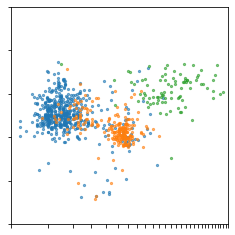

In [213]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i in np.unique(ind):
    ax.scatter(np.log10(acorr_peak[indssort][ind==i]), spk_width[indssort][ind==i]*1000, s = 5, alpha = 0.6,
              label = str(i))
plt.xticks(xt, ['' for x in xt])#yt)

ax.set_xlim(xt[0], xt[-1])
ax.set_ylim(0, 1)

plt.yticks(np.linspace(0,1,6), ['' for x in np.linspace(0,1,6)])#yt)

ax.set_aspect(1/ax.get_data_ratio())


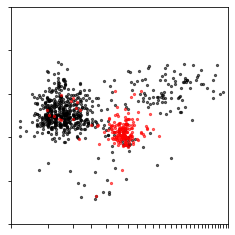

In [215]:
fig = plt.figure()
ax = fig.add_subplot(111)
cols = ['k', 'r']
for i in np.unique(is_conj):
    ax.scatter(np.log10(acorr_peak[indssort][is_conj[indssort]==i]), spk_width[indssort][is_conj[indssort]==i]*1000, 
               s = 5, alpha = 0.6, label = str(i), c = cols[i])

plt.xticks(xt, ['' for x in xt])#yt)

ax.set_xlim(xt[0], xt[-1])
ax.set_ylim(0, 1)

plt.yticks(np.linspace(0,1,6), ['' for x in np.linspace(0,1,6)])#yt)

ax.set_aspect(1/ax.get_data_ratio())


In [245]:
np.savez('grid_cell_classes_indices', 
         R1_ind = ind[:189],
         R2_ind = ind[189:361],
         R3_ind = ind[361:544],
         Q1_ind = ind[544:641],
         Q2_ind = ind[641:707],
         S1_ind = ind[707:],         
        )

Compute Bursty R1

In [232]:
rat_name, mod_name, sess_name, day_name = ('R', '1',  'SWS_bursty', 'day2',)


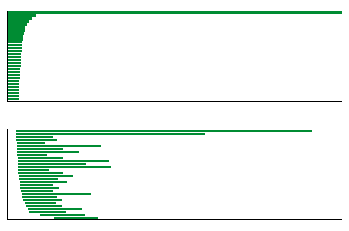

In [223]:
bRoll = False
dim = 6
ph_classes = [0,1] # Decode the ith most persistent cohomology class
num_circ = len(ph_classes)
dec_tresh = 0.99
metric = 'cosine'
maxdim = 1
coeff = 47
active_times = 15000
k = 1000
num_times = 5
n_points = 1200
nbs = 800
sspikes = get_spikes(rat_name, mod_name, day_name, sess_name,  bSmooth = True, bSpeed = False)
num_neurons = len(sspikes[0,:])

times_cube = np.arange(0,len(sspikes[:,0]),num_times)
movetimes = np.sort(np.argsort(np.sum(sspikes[times_cube,:],1))[-active_times:])
movetimes = times_cube[movetimes]

dim_red_spikes_move_scaled,__,__ = pca(preprocessing.scale(sspikes[movetimes,:]), dim = dim)
indstemp,dd,fs  = sample_denoising(dim_red_spikes_move_scaled,  k, 
                                    n_points, 1, metric)
dim_red_spikes_move_scaled = dim_red_spikes_move_scaled[indstemp,:]
X = squareform(pdist(dim_red_spikes_move_scaled, metric))
knn_indices = np.argsort(X)[:, :nbs]
knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()
sigmas, rhos = smooth_knn_dist(knn_dists, nbs, local_connectivity=0)
rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
result = coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0]))
result.eliminate_zeros()
transpose = result.transpose()
prod_matrix = result.multiply(transpose)
result = (result + transpose - prod_matrix)
result.eliminate_zeros()
d = result.toarray()
d = -np.log(d)
np.fill_diagonal(d,0)

persistence = ripser(d, maxdim=maxdim, coeff=coeff, do_cocycles= True, distance_matrix = True)

plot_barcode(persistence['dgms'])

np.savez_compressed('Toroidal_topology_grid_cell_data/Results/' + 
    rat_name + '_' + mod_name + '_' + sess_name  + day_name  + '_persistence', 
    persistence = persistence, indstemp = indstemp,  movetimes = movetimes)


In [ ]:
############ Decode cocycles ################
diagrams = persistence["dgms"] # the multiset describing the lives of the persistence classes
cocycles = persistence["cocycles"][1] # the cocycle representatives for the 1-dim classes
dists_land = persistence["dperm2all"] # the pairwise distance between the points 
births1 = diagrams[1][:, 0] #the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1] #the time of death for the 1-dim classes
deaths1[np.isinf(deaths1)] = 0
lives1 = deaths1-births1 # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)
coords1 = np.zeros((num_circ, len(indstemp)))
threshold = births1[iMax[-2]] + (deaths1[iMax[-2]] - births1[iMax[-2]])*dec_tresh
for c in ph_classes:
    cocycle = cocycles[iMax[-(c+1)]]
    coords1[c,:],inds = get_coords(cocycle, threshold, len(indstemp), dists_land, coeff)

num_neurons = len(sspikes[0,:])
centcosall = np.zeros((num_neurons, 2, n_points))
centsinall = np.zeros((num_neurons, 2, n_points))

dspk = preprocessing.scale(sspikes[movetimes[indstemp],:])

for neurid in range(num_neurons):
    spktemp = dspk[:, neurid].copy()
    centcosall[neurid,:,:] = np.multiply(np.cos(coords1[:, :]*2*np.pi),spktemp)
    centsinall[neurid,:,:] = np.multiply(np.sin(coords1[:, :]*2*np.pi),spktemp)



In [243]:
sigma = 1500
sspikes = get_spikes(rat_name, mod_name, day_name, sess_name , bSmooth = True, bSpeed = False,
                     smoothing_width = sigma)
spikes = get_spikes(rat_name, mod_name, day_name, sess_name, bSmooth = False, bSpeed = False)

times = np.where(np.sum(spikes>0, 1)>=1)[0]
dspk = preprocessing.scale(sspikes)
sspikes = sspikes[times,:]
dspk = dspk[times,:]

a = np.zeros((len(sspikes[:,0]), 2, num_neurons))
for n in range(num_neurons):
    a[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centcosall[n,:,:],1))

c = np.zeros((len(sspikes[:,0]), 2, num_neurons))
for n in range(num_neurons):
    c[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centsinall[n,:,:],1))

mtot2 = np.sum(c,2)
mtot1 = np.sum(a,2)
coords = np.arctan2(mtot2,mtot1)%(2*np.pi)

sspikes_of,__,__,__,__ = get_spikes(rat_name, mod_name, day_name, 'OF_bursty',
                                 bSmooth = True, bSpeed = True, smoothing_width = sigma)

spikes_of,__,__,__,__ = get_spikes(rat_name, mod_name, day_name, 'OF_bursty',
                                 bSmooth = False, bSpeed = True)

dspk =preprocessing.scale(sspikes_of)
times_box = np.where(np.sum(spikes_of>0, 1)>=1)[0]
dspk = dspk[times_box,:]

a = np.zeros((len(times_box), 2, num_neurons))
for n in range(num_neurons):
    a[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centcosall[n,:,:],1))

c = np.zeros((len(times_box), 2, num_neurons))
for n in range(num_neurons):
    c[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centsinall[n,:,:],1))

mtot2 = np.sum(c,2)
mtot1 = np.sum(a,2)
coordsbox = np.arctan2(mtot2,mtot1)%(2*np.pi)
file_name = rat_name + '_' + mod_name + '_' + sess_name
if len(day_name)>0:
    file_name += '_' + day_name
np.savez_compressed('Toroidal_topology_grid_cell_data/Results/' + file_name  + '_decoding', 
                    coords = coords, coordsbox = coordsbox,  times = times, 
                    times_box = times_box, centcosall = centcosall, centsinall = centsinall)


In [252]:
rat_name, mod_name, sess_name, day_name = ('R', '1', 'SWS_bursty', 'day2')
fit_para(rat_name, mod_name, sess_name, day_name)

C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:547: OptimizeWarning: Unknown solver options: gtol


In [253]:
rat_name, mod_name, sess_name, day_name = ('R', '1', 'OF', 'day2')
fit_para(rat_name, mod_name, sess_name, day_name)

C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:547: OptimizeWarning: Unknown solver options: gtol


<Figure size 432x288 with 0 Axes>

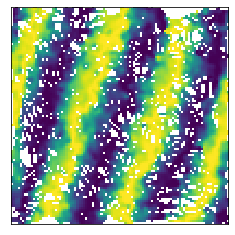

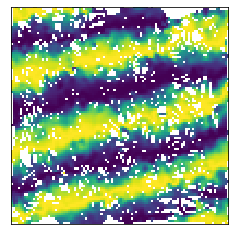

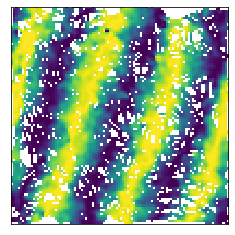

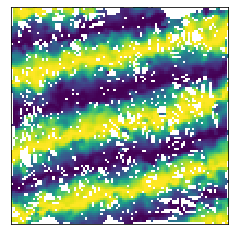

In [327]:
rat_name, mod_name,  sess_name_0, sess_name_1, day_name = ('R', '1', 'SWS_bursty', 'OF', 'day2')
toroidal_alignment(rat_name, mod_name, sess_name_0, sess_name_1, day_name, bPlot = True)
toroidal_alignment(rat_name, mod_name,  sess_name_1, sess_name_1, day_name, bPlot = False)

Cumulative distributions

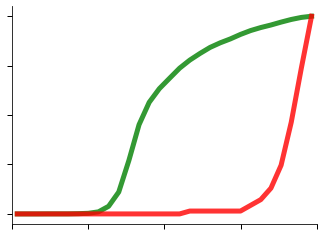

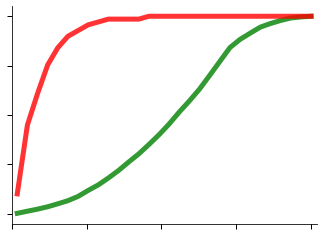

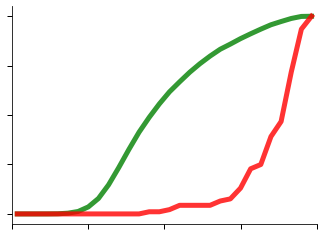

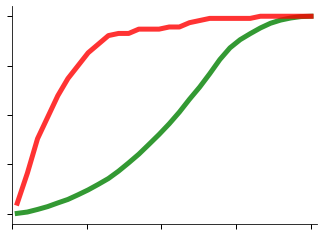

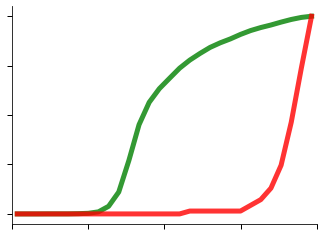

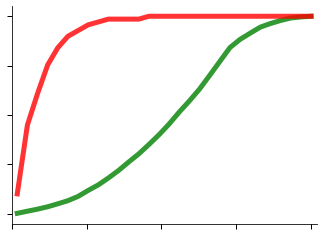

In [377]:

file_name =   rat_name + '_' + mod_name + '_' + sess_name_0 + '_' + sess_name_1 + '_' + day_name
f = np.load('Toroidal_topology_grid_cell_data/Results/' + file_name + '_alignment_dec.npz', allow_pickle = True)
cc_sws = f['csess']
times_sws = f['times']
f.close()
            
file_name =   rat_name + '_' + mod_name + '_' + sess_name_1 + '_' + sess_name_1 + '_' + day_name
f = np.load('Toroidal_topology_grid_cell_data/Results/' + file_name + '_alignment_dec.npz', allow_pickle = True)
cc_of = f['csess']
times_of = f['times']
f.close()

for k in ['_bursty', '_theta', '_nonbursty']:
    spk_of = get_spikes('R', '1', 'day2', 'OF' + k,  bSmooth = False, bSpeed = True)[0]
    spk_sws = get_spikes('R', '1', 'day2', 'SWS' + k, bSmooth = False, bSpeed = False)

    mtots_of, mcs_of = get_ratemaps(cc_of, spk_of[times_of,:])
    mtots_sws, mcs_sws = get_ratemaps(cc_sws, spk_sws[times_sws,:])
    
    corr, dist, corr_shuffle, dist_shuffle = get_corr_dist(mcs_of,mcs_sws, mtots_of, mtots_sws)
    
    plot_cumulative_stat(corr, corr_shuffle, (-1,1), 1, 
                         [-1, -0.5, 0.0, 0.5, 1.0], [0.0, 0.25, 0.5, 0.75, 1.0], [-1,1], [-0.05,1.05])
    plot_cumulative_stat(dist, dist_shuffle, (0,np.sqrt(2)*np.pi), 180/np.pi, 
                         [0, 62.5, 125, 187.5, 250], [0.0, 0.25, 0.5, 0.75, 1.0], [0,255], [-0.05,1.05])
    


### Conjunctive HD tuning

In [378]:
rat_name, mod_name, sess_name, day_name = ('R', '1',  'SWS_theta', 'day2')


C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log


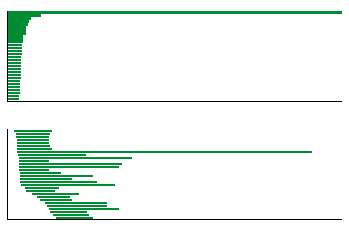

In [380]:
bRoll = False
dim = 6
ph_classes = [0,1] # Decode the ith most persistent cohomology class
num_circ = len(ph_classes)
dec_tresh = 0.99
metric = 'cosine'
maxdim = 1
coeff = 47
active_times = 15000
k = 1000
num_times = 5
n_points = 1200
nbs = 800

sspikes = get_spikes(rat_name, mod_name, day_name, sess_name,  bSmooth = True, bSpeed = False)
num_neurons = len(sspikes[0,:])

times_cube = np.arange(0,len(sspikes[:,0]),num_times)
movetimes = np.sort(np.argsort(np.sum(sspikes[times_cube,:],1))[-active_times:])
movetimes = times_cube[movetimes]

dim_red_spikes_move_scaled,__,__ = pca(preprocessing.scale(sspikes[movetimes,:]), dim = dim)
indstemp,dd,fs  = sample_denoising(dim_red_spikes_move_scaled,  k, 
                                    n_points, 1, metric)
dim_red_spikes_move_scaled = dim_red_spikes_move_scaled[indstemp,:]
X = squareform(pdist(dim_red_spikes_move_scaled, metric))
knn_indices = np.argsort(X)[:, :nbs]
knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()
sigmas, rhos = smooth_knn_dist(knn_dists, nbs, local_connectivity=0)
rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
result = coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0]))
result.eliminate_zeros()
transpose = result.transpose()
prod_matrix = result.multiply(transpose)
result = (result + transpose - prod_matrix)
result.eliminate_zeros()
d = result.toarray()
d = -np.log(d)
np.fill_diagonal(d,0)

persistence = ripser(d, maxdim=maxdim, coeff=coeff, do_cocycles= True, distance_matrix = True)

plot_barcode(persistence['dgms'])

np.savez_compressed('Toroidal_topology_grid_cell_data/Results/' + 
    rat_name + '_' + mod_name + '_' + sess_name + '_theta_'  + day_name  + '_persistence', 
    persistence = persistence, indstemp = indstemp,  movetimes = movetimes)


In [381]:
############ Decode cocycles ################
diagrams = persistence["dgms"] # the multiset describing the lives of the persistence classes
cocycles = persistence["cocycles"][1] # the cocycle representatives for the 1-dim classes
dists_land = persistence["dperm2all"] # the pairwise distance between the points 
births1 = diagrams[1][:, 0] #the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1] #the time of death for the 1-dim classes
deaths1[np.isinf(deaths1)] = 0
lives1 = deaths1-births1 # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)
coords1 = np.zeros((num_circ, len(indstemp)))
threshold = births1[iMax[-2]] + (deaths1[iMax[-2]] - births1[iMax[-2]])*dec_tresh
for c in ph_classes:
    cocycle = cocycles[iMax[-(c+1)]]
    coords1[c,:],inds = get_coords(cocycle, threshold, len(indstemp), dists_land, coeff)

num_neurons = len(sspikes[0,:])
centcosall = np.zeros((num_neurons, 2, n_points))
centsinall = np.zeros((num_neurons, 2, n_points))

dspk = preprocessing.scale(sspikes[movetimes[indstemp],:])

for neurid in range(num_neurons):
    spktemp = dspk[:, neurid].copy()
    centcosall[neurid,:,:] = np.multiply(np.cos(coords1[:, :]*2*np.pi),spktemp)
    centsinall[neurid,:,:] = np.multiply(np.sin(coords1[:, :]*2*np.pi),spktemp)



In [412]:
sigma = 100000
sspikes_of,__,__,__,__ = get_spikes(rat_name, mod_name, day_name, 'OF_theta',
                                 bSmooth = True, bSpeed = True, smoothing_width = sigma)

dspk =preprocessing.scale(sspikes_of)

a = np.zeros((len(dspk[:,0]), 2, num_neurons))
for n in range(num_neurons):
    a[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centcosall[n,:,:],1))

c = np.zeros((len(dspk[:,0]), 2, num_neurons))
for n in range(num_neurons):
    c[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centsinall[n,:,:],1))

mtot2 = np.sum(c,2)
mtot1 = np.sum(a,2)
coordsbox = np.arctan2(mtot2,mtot1)%(2*np.pi)


0.8576425411784621


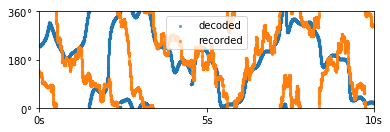

In [414]:
xx, yy, aa, tt, speed = load_pos(rat_name, 'OF', day_name, bSpeed = True)

tt = tt[speed>2.5]
xx = xx[speed>2.5]
yy = yy[speed>2.5]
aa = aa[speed>2.5]

cctmp = coordsbox[:,0].copy()
nnans = (~np.isnan(aa)) & (~np.isnan(cctmp[:]))
circmin = np.arctan2(np.mean(np.sin(cctmp[nnans]-aa[nnans])),
                     np.mean(np.cos(cctmp[nnans]-aa[nnans])))%(2*np.pi)
cc1 = (cctmp[:]-circmin)%(2*np.pi)
circdiff = np.mean(np.abs(np.arctan2(np.sin(cc1[nnans]-aa[nnans]),
                     np.cos(cc1[nnans]-aa[nnans]))))
print(circdiff)
t0, t1 = 800,10800
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.arange(t0,t1), cc1[t0:t1]/(2*np.pi)*360, 
           lw = 0.0, alpha = 0.7, label ='decoded', s = 10)
ax.scatter(np.arange(t0,t1), aa[t0:t1]/(2*np.pi)*360, 
           lw = 0.0, alpha = 0.7, label ='recorded', s = 10)
ax.set_xlim([t0,t1])
ax.set_ylim([0,2*np.pi/(2*np.pi)*360])

ax.set_yticks([0,180,360])
ax.set_xticks([800,5800, 10800])
ax.set_yticklabels(['', '', ''])
ax.set_xticklabels(['', '', '', ])

ax.set_yticklabels(['0$\degree$', '180$\degree$', '360$\degree$'])
ax.set_xticklabels(['0s', '5s', '10s', '15s', '20s'])

ax.set_aspect(8)
plt.legend()

#### Shane

In [417]:
rat_name, mod_name, sess_name, day_name = ('S', '1',  'SWS_theta', '')


C:\Users\erihe\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log


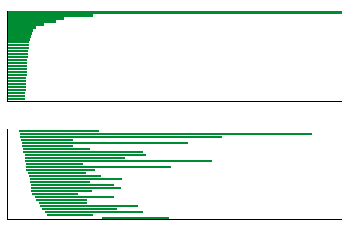

In [418]:
bRoll = False
dim = 6
ph_classes = [0,1] # Decode the ith most persistent cohomology class
num_circ = len(ph_classes)
dec_tresh = 0.99
metric = 'cosine'
maxdim = 1
coeff = 47
active_times = 15000
k = 1000
num_times = 5
n_points = 1200
nbs = 800

sspikes = get_spikes(rat_name, mod_name, day_name, sess_name,  bSmooth = True, bSpeed = False)
num_neurons = len(sspikes[0,:])

times_cube = np.arange(0,len(sspikes[:,0]),num_times)
movetimes = np.sort(np.argsort(np.sum(sspikes[times_cube,:],1))[-active_times:])
movetimes = times_cube[movetimes]

dim_red_spikes_move_scaled,__,__ = pca(preprocessing.scale(sspikes[movetimes,:]), dim = dim)
indstemp,dd,fs  = sample_denoising(dim_red_spikes_move_scaled,  k, 
                                    n_points, 1, metric)
dim_red_spikes_move_scaled = dim_red_spikes_move_scaled[indstemp,:]
X = squareform(pdist(dim_red_spikes_move_scaled, metric))
knn_indices = np.argsort(X)[:, :nbs]
knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()
sigmas, rhos = smooth_knn_dist(knn_dists, nbs, local_connectivity=0)
rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
result = coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0]))
result.eliminate_zeros()
transpose = result.transpose()
prod_matrix = result.multiply(transpose)
result = (result + transpose - prod_matrix)
result.eliminate_zeros()
d = result.toarray()
d = -np.log(d)
np.fill_diagonal(d,0)

persistence = ripser(d, maxdim=maxdim, coeff=coeff, do_cocycles= True, distance_matrix = True)

plot_barcode(persistence['dgms'])

np.savez_compressed('Toroidal_topology_grid_cell_data/Results/' + 
    rat_name + '_' + mod_name + '_' + sess_name + '_theta_'  + day_name  + '_persistence', 
    persistence = persistence, indstemp = indstemp,  movetimes = movetimes)


In [419]:
############ Decode cocycles ################
diagrams = persistence["dgms"] # the multiset describing the lives of the persistence classes
cocycles = persistence["cocycles"][1] # the cocycle representatives for the 1-dim classes
dists_land = persistence["dperm2all"] # the pairwise distance between the points 
births1 = diagrams[1][:, 0] #the time of birth for the 1-dim classes
deaths1 = diagrams[1][:, 1] #the time of death for the 1-dim classes
deaths1[np.isinf(deaths1)] = 0
lives1 = deaths1-births1 # the lifetime for the 1-dim classes
iMax = np.argsort(lives1)
coords1 = np.zeros((num_circ, len(indstemp)))
threshold = births1[iMax[-2]] + (deaths1[iMax[-2]] - births1[iMax[-2]])*dec_tresh
for c in ph_classes:
    cocycle = cocycles[iMax[-(c+1)]]
    coords1[c,:],inds = get_coords(cocycle, threshold, len(indstemp), dists_land, coeff)

num_neurons = len(sspikes[0,:])
centcosall = np.zeros((num_neurons, 2, n_points))
centsinall = np.zeros((num_neurons, 2, n_points))

dspk = preprocessing.scale(sspikes[movetimes[indstemp],:])

for neurid in range(num_neurons):
    spktemp = dspk[:, neurid].copy()
    centcosall[neurid,:,:] = np.multiply(np.cos(coords1[:, :]*2*np.pi),spktemp)
    centsinall[neurid,:,:] = np.multiply(np.sin(coords1[:, :]*2*np.pi),spktemp)



In [420]:
sigma = 100000
sspikes_of,__,__,__,__ = get_spikes(rat_name, mod_name, day_name, 'OF_theta',
                                 bSmooth = True, bSpeed = True, smoothing_width = sigma)

dspk =preprocessing.scale(sspikes_of)

a = np.zeros((len(dspk[:,0]), 2, num_neurons))
for n in range(num_neurons):
    a[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centcosall[n,:,:],1))

c = np.zeros((len(dspk[:,0]), 2, num_neurons))
for n in range(num_neurons):
    c[:,:,n] = np.multiply(dspk[:,n:n+1],np.sum(centsinall[n,:,:],1))

mtot2 = np.sum(c,2)
mtot1 = np.sum(a,2)
coordsbox = np.arctan2(mtot2,mtot1)%(2*np.pi)


0.7439584338002855


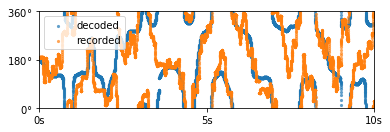

In [422]:
xx, yy, aa, tt, speed = load_pos(rat_name, 'OF', day_name, bSpeed = True)

tt = tt[speed>2.5]
xx = xx[speed>2.5]
yy = yy[speed>2.5]
aa = aa[speed>2.5]

cctmp = 2*np.pi-coordsbox[:,0].copy()
nnans = (~np.isnan(aa)) & (~np.isnan(cctmp[:]))
circmin = np.arctan2(np.mean(np.sin(cctmp[nnans]-aa[nnans])),
                     np.mean(np.cos(cctmp[nnans]-aa[nnans])))%(2*np.pi)
cc1 = (cctmp[:]-circmin)%(2*np.pi)
circdiff = np.mean(np.abs(np.arctan2(np.sin(cc1[nnans]-aa[nnans]),
                     np.cos(cc1[nnans]-aa[nnans]))))
print(circdiff)
t0, t1 = 800,10800
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.arange(t0,t1), cc1[t0:t1]/(2*np.pi)*360, 
           lw = 0.0, alpha = 0.7, label ='decoded', s = 10)
ax.scatter(np.arange(t0,t1), aa[t0:t1]/(2*np.pi)*360, 
           lw = 0.0, alpha = 0.7, label ='recorded', s = 10)
ax.set_xlim([t0,t1])
ax.set_ylim([0,2*np.pi/(2*np.pi)*360])

ax.set_yticks([0,180,360])
ax.set_xticks([800,5800, 10800])
ax.set_yticklabels(['', '', ''])
ax.set_xticklabels(['', '', '', ])

ax.set_yticklabels(['0$\degree$', '180$\degree$', '360$\degree$'])
ax.set_xticklabels(['0s', '5s', '10s', '15s', '20s'])

ax.set_aspect(8)
plt.legend()